In [41]:
import matplotlib.pyplot as plt
from matplotlib.path import Path
import pandas as pd
import os
import sys
import seaborn as sns

# Get notebook and parent dir
current_dir = os.path.dirname(os.path.abspath('__file__')) 
parent_dir = os.path.dirname(current_dir)

# Set path to pedophysics module 
pedophysics_code_path = os.path.join(parent_dir)
sys.path.insert(0, pedophysics_code_path)

from pedophysics import predict, Soil
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from scipy.optimize import root
from scipy.stats import spearmanr
from IPython.display import clear_output

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split
from scipy.stats import pearsonr
from scipy import stats

from PyPDF2 import PdfMerger

# Electromagnetic induction data inversion package
from plots import *
from PM import *
%matplotlib inline

pd.set_option('display.max_columns', None)
from utils.spatial_utils import get_coincident

pd.option_context('mode.use_inf_as_na', True)

In [42]:
site = 'M'

# Parameters
extract = 0.5 # 2.5
# Inversion parameters
sample_loc = 'closest' # 'mean' or 'closest'
interface = 'observed' # log-defined or observed
FM = 'FSeq' #'CS', 'FSlin' or 'FSeq'
MinM = 'Gauss-Newton'  
alpha = 0.07
remove_coil = False
start_avg = True
constrain = False
################################################
# Define input datatype and source folder

inv = True
em_intype = 'reca'   # 'reca', 'LIN' 
cal = 'calibrated' # 'calibrated', 'non_calibrated'

### Results plot

In [43]:
if site == 'P':
    profile_prefix = 'proefhoeve'
    emfile_prefix = 'proefhoeve_21HS'

else:
    profile_prefix = 'middelkerke'
    emfile_prefix = 'middelkerke_421S'

## Load data

In [44]:
datafolder = 'data' # data folder
data_inv_folder = 'data/inverted'
data_sanalysis_folder = 'data/soil_analyses'

inv_s = os.path.join(data_inv_folder, f'{emfile_prefix}_inverted_samples_{extract}_{sample_loc}_{interface}_{FM}_{MinM}_{alpha}_{remove_coil}_{start_avg}_{constrain}.csv')
    
instrument_code = '21HS' # 421S, '21HS'

if site == 'M':
    instrument_code = '421S'

cal_folder = os.path.join(datafolder, cal)

if cal == 'calibrated':
    em_survey = os.path.join(cal_folder, f'{emfile_prefix}_raw_{cal}_{em_intype}_{extract}.csv')

else:
    em_survey = os.path.join(cal_folder, f'{emfile_prefix}_raw_{cal}_{em_intype}.csv')

sampleprop = os.path.join(data_sanalysis_folder, f'{profile_prefix}_soil_analysis.csv')

# Profile smoothing parameters 
window_size = 1 # Define your window size for simple moving average filter (1 = no filtering)

# 1.0 Data import and structuring into dataframe
em_survey = pd.read_csv(em_survey, sep=',', header=0)
print('em_survey', em_survey.head())
inverted = pd.read_csv(inv_s, sep=',', header=0)
samples_analysis = pd.read_csv(sampleprop, sep=',', header=0)

em_sample_prop = get_coincident(em_survey, samples_analysis)

em_survey              x            y         z         t      HCP1QP     PRP1QP  \
0  41563.15402  204149.1651  0.358554  45474.80  189.167023  89.069323   
1  41563.15309  204149.1669  0.358554  45475.00  189.167023  89.069323   
2  41563.15194  204149.1691  0.358554  45475.17  189.167023  89.069323   
3  41563.15023  204149.1724  0.358554  45475.38  189.167023  89.069323   
4  41563.14844  204149.1758  0.358554  45475.58  189.167023  89.069323   

       HCP2QP     PRP2QP      HCP4QP      PRP4QP  HCP1IP  PRP1IP  HCP2IP  \
0  282.372325  159.08056  414.693385  257.572840    2.01    0.04    7.52   
1  282.372325  159.08056  414.995167  256.748790    2.01    0.04    7.52   
2  282.372325  159.08056  416.507620  256.748790    2.01    0.04    7.52   
3  282.372325  159.08056  415.297176  256.748790    2.01    0.04    7.52   
4  282.372325  159.08056  414.090045  256.419256    2.01    0.04    7.52   

   PRP2IP  HCP4IP  PRP4IP  
0    0.66   37.68    7.34  
1    0.66   37.40    7.34  
2   

# Data Analysis
### Data wrangling

In [45]:
ds = em_sample_prop.copy()

# Caclculate Bulk EC from HydraProbe data at 50Mhz
offset = 4
water_perm = 80
ds['bulk_ec_hp'] = logsdon(50e6, ds.rperm, ds.iperm)

ds['bulk_ec_dc_hp'] = predict.BulkECDC(Soil(frequency_ec = 50e6,
                                              bulk_ec = ds.bulk_ec_hp.values))

ds['bulk_ec_tc_hp'] = SheetsHendrickxEC( ds.bulk_ec_hp, ds.temp)
ds['bulk_ec_dc_tc_hp'] = predict.BulkECDCTC(Soil(temperature = ds.temp.values,
                                                    bulk_ec_dc = ds.bulk_ec_dc_hp.values
                                                    ))

# Caclculate Water EC from HydraProbe data at 50Mhz
ds['water_ec_hp'] = Hilhorst(ds.bulk_ec_hp, ds.rperm, water_perm, offset)
ds['water_ec_hp_t'] = WraithOr(ds.water_ec_hp, ds.temp)
ds['iperm_water_t'] = ds.water_ec_hp_t/(50e6*2*pi*epsilon_0)

inv_columns = inverted.columns[3:-2]
ds[inv_columns] = np.nan

for idc, c in enumerate(inv_columns):

    for i in range(len(inverted.x)):
        ds.loc[ds.code == i+1, c] = inverted.loc[i, c]

def closest_ec(row):
    depth = row['depth']
    # Filter columns that start with 'EC_' but not 'EC_end'
    ec_cols = [col for col in row.index if col.startswith('EC_') and col != 'EC_end']
    # Convert the part after 'EC_' to float and calculate the absolute difference with depth
    differences = {col: abs(depth/100 - float(col.split('_')[1])) for col in ec_cols}
    # Find the column name with the minimum difference
    closest_col = min(differences, key=differences.get)
    return row[closest_col]

# Apply the function to each row
ds['bulk_ec_inv'] = ds.apply(closest_ec, axis=1)

ds['bulk_ec_dc_tc_inv'] = predict.BulkECDCTC(Soil(temperature = ds.temp.values+273.15,
                                                      frequency_ec = 9e3,
                                                      bulk_ec = ds.bulk_ec_inv.values/1000))*1000


ds['ideal_bulk_ec'] = predict.BulkEC(
                                        Soil(temperature = ds.temp.values+273.15,
                                             water = ds.vwc.values,
                                             clay = ds.clay.values,
                                             bulk_density = ds.bd.values,
                                             water_ec = ds.water_ec_hp.values,
                                             frequency_ec = 9e3
                                            )

)

if inv == True:
     feature_set = ['bulk_ec_inv']
else:         
    if instrument_code == '21HS':
        feature_set = [
            'HCPHQP',
            'HCP1QP',
            'HCP2QP',
            'PRPHQP',
            'PRP1QP',
            'PRP2QP',
        #    'bulk_ec_inv',
        ]
        
    elif instrument_code == '421S':
        feature_set = [
            'HCP1QP',
            'HCP2QP',
            'HCP4QP',
            'PRP1QP',
            'PRP2QP',
            'PRP4QP',
        #    'bulk_ec_inv',
        ]
    
target_set = [
    'vwc',
    'CEC',
    'clay',
    'bd',
    'water_ec_hp'
]
#folder_path = 'output_tables/'
#file_name = 'ds_'+profile_prefix+'.csv'
#ds.to_csv(folder_path + file_name, index=False)
ds_all = get_coincident(em_sample_prop, ds)

ds_all_filename = f'samps_all_{emfile_prefix}_inverted_samples_{extract}_{sample_loc}_{interface}_{FM}_{MinM}_{alpha}_{remove_coil}_{start_avg}_{constrain}.csv'
full_path = os.path.join(data_inv_folder, ds_all_filename)
ds_all.to_csv(full_path, index=False)


### Correlations

c:\Users\mendo\anaconda3_2\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


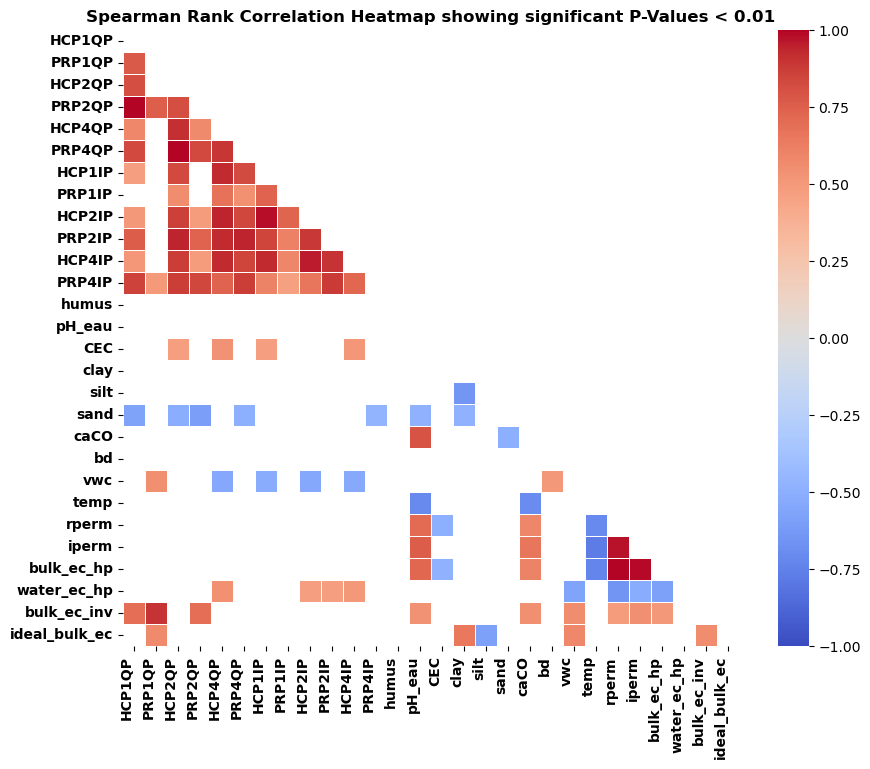

In [46]:
filtered_features = ['x', 'y', 'z', 't', 'geometry', 'code', 'TOC', 'x_clhs', 'y_clhs', 'depth', 'copeky', 'bulk_ec_dc_hp', 'bulk_ec_tc_hp', 'bulk_ec_dc_tc_hp', 'water_ec_hp_t', 'iperm_water_t', 'bulk_ec_dc_tc_inv']

# Filter out columns that start with 'EC_' and are not constant
non_ec_columns = [col for col in ds.columns if col not in filtered_features and not col.startswith('EC_') and not col.endswith('_inph')]

# Calculate the Spearman rank correlation coefficients and p-values
corr, p_value = spearmanr(ds[non_ec_columns], nan_policy='omit')

# Convert to DataFrame for easier plotting
corr_df = pd.DataFrame(corr, index=non_ec_columns, columns=non_ec_columns)
p_value_df = pd.DataFrame(p_value, index=non_ec_columns, columns=non_ec_columns)

# Create a mask for significant p-values (e.g., p < 0.01)
p_value_mask = 0.01
significant_mask = p_value_df < p_value_mask

# Mask for the upper triangle
mask = np.triu(np.ones_like(corr_df, dtype=bool))

# Combine the masks
final_mask = mask | ~significant_mask

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=final_mask, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, vmin=-1, vmax=1, annot_kws={"size": 8})

# Adjust layout for better readability
plt.xticks(rotation=90, ha='right', fontsize=10, fontweight='bold')
plt.yticks(rotation=0, fontsize=10, fontweight='bold')
plt.title('Spearman Rank Correlation Heatmap showing significant P-Values < '+str(p_value_mask), fontsize=12, fontweight='bold')

# Show the plot

folder_path = 'output_images/'
filename = f"Corr_{site}_{cal}_{em_intype}.pdf"
plt.savefig(folder_path + filename)
plt.show()

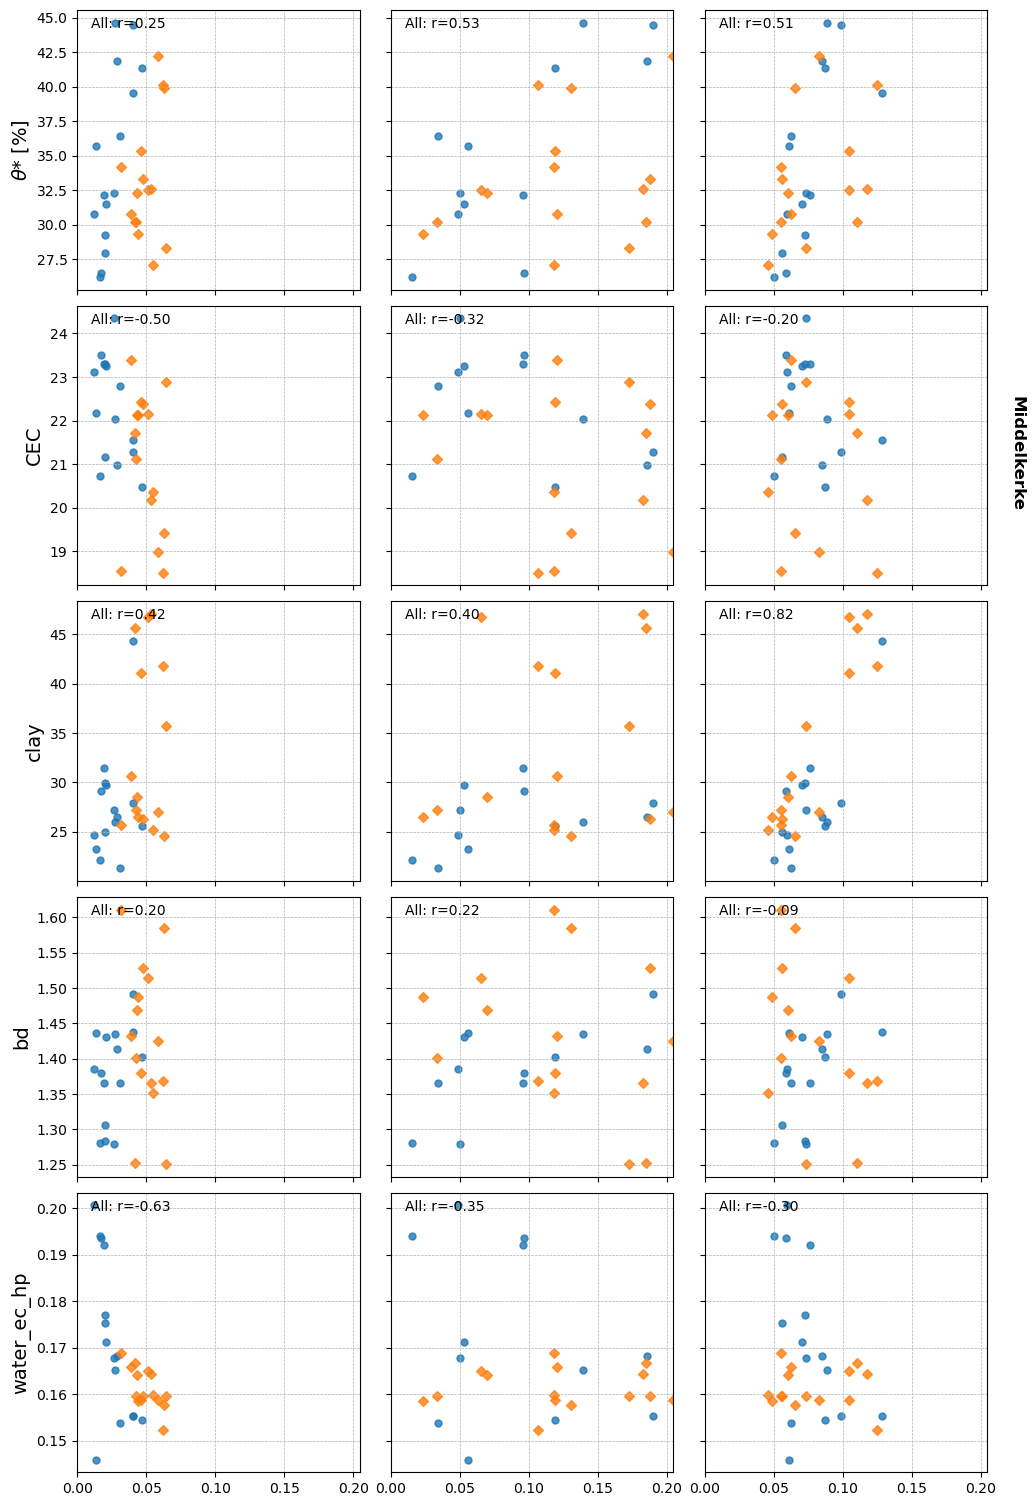

<Figure size 640x480 with 0 Axes>

In [47]:
ds['bulk_ec_inv_mS'] = ds.bulk_ec_inv/1000
preds = ['bulk_ec_hp', 'bulk_ec_inv_mS', 'ideal_bulk_ec']

f5(ds, preds, target_set, site)

plt.subplots_adjust(top=0.7)  # You can adjust this value as needed
plt.suptitle(f"Correlation Plots for {profile_prefix}", fontweight='bold', fontsize=16, y=0.999)  # Adjust y as needed
plt.tight_layout(pad=0.5, w_pad=0.4, h_pad=0.8)

folder_path = 'output_images/'
filename = f"Plot_{site}.pdf"
plt.savefig(folder_path + filename, dpi=300)
plt.show()

# Deterministic modelling

## Implementation

In [48]:
bulk_ec_inv_50cm = ds.bulk_ec_inv[ds['depth']==50]
bulk_ec_inv_10cm = ds.bulk_ec_inv[ds['depth']==10]

clay_50cm = np.mean(ds.clay[ds['depth']==50])
clay_10cm = np.mean(ds.clay[ds['depth']==10])
bd_50cm = np.mean(ds.bd[ds['depth']==50])
bd_10cm = np.mean(ds.bd[ds['depth']==10])
water_ec_hp_50cm = np.mean(ds.water_ec_hp[ds['depth']==50])
water_ec_hp_10cm = np.mean(ds.water_ec_hp[ds['depth']==10])
water_ec_hp_50cm_t = np.mean(ds.water_ec_hp_t[ds['depth']==50])
water_ec_hp_10cm_t = np.mean(ds.water_ec_hp_t[ds['depth']==10])
clay_mean = np.mean(ds.clay)
bd_mean = np.mean(ds.bd)
water_ec_hp_mean = np.mean(ds.water_ec_hp)
water_ec_hp_mean_t = np.mean(ds.water_ec_hp_t)
temp_50cm = np.mean(ds.temp[ds['depth']==50])
temp_10cm = np.mean(ds.temp[ds['depth']==10])
temp_mean = np.mean(ds.temp)
vwc_50cm = np.mean(ds.vwc[ds['depth']==50])
vwc_10cm = np.mean(ds.vwc[ds['depth']==10])
vwc_mean = np.mean(ds.vwc)
f_ec = 9000
t_conv = 273.15
t_mean_conv = temp_mean+t_conv
t_50cm_conv = temp_50cm+t_conv
t_10cm_conv = temp_10cm+t_conv

In [49]:
def deterministic(feature, target, df, iters=100, round_n=3):
  df.reset_index(drop=True, inplace=True)

  idx_layer_10 = df[df['depth'] == 10].index
  idx_layer_50 = df[df['depth'] == 50].index

  # Select data using boolean masks
  X_layer_10 = df.loc[idx_layer_10, feature].values.reshape(-1, 1)
  Y_layer_10 = df.loc[idx_layer_10, target].values
  X_layer_50 = df.loc[idx_layer_50, feature].values.reshape(-1, 1)
  Y_layer_50 = df.loc[idx_layer_50, target].values

  # Preallocate lists
  DR2_LS, DRMSE_LS = [None] * iters, [None] * iters
  DR2_LT, DRMSE_LT = [None] * iters, [None] * iters
  DR2_10, DRMSE_10 = [None] * iters, [None] * iters
  DR2_50, DRMSE_50 = [None] * iters, [None] * iters
  DR2_ID, DRMSE_ID, ypred_ID_ = [None] * iters, [None] * iters, [None] * iters
  y_ = [None] * iters
  
  for i in range(iters):
    ### Split data of 10cm layer and keep track of test indices
    X_train10, X_test10, y_train10, y_test10, idx_train10, idx_test10 = train_test_split(X_layer_10, Y_layer_10, idx_layer_10, test_size=0.3, random_state=i)
    ### Split data of 50cm layer and keep track of test indices
    X_train50, X_test50, y_train50, y_test50, idx_train50, idx_test50 = train_test_split(X_layer_50, Y_layer_50, idx_layer_50, test_size=0.3, random_state=i)
    ### Combine test indices from both layers
    idx_test = np.concatenate((idx_test10, idx_test50))
    y_test = np.concatenate((y_test10, y_test50)).flatten()
    X_test = (np.concatenate((X_test10, X_test50))/1000).flatten()
    y_[i] = y_test
    
    ### Predict using layer together 
    LT = Soil( 
                bulk_ec = X_test,
                frequency_ec=f_ec,
                clay = clay_mean,
                bulk_density = bd_mean,
                water_ec = water_ec_hp_mean_t,
                temperature = t_mean_conv
                  )
    Dypred_LT = predict.Water(LT)
    DR2_LT[i] = round(r2_score(y_test, Dypred_LT), round_n)
    DRMSE_LT[i] = round(RMSE(y_test, Dypred_LT), round_n)

    ### Predict using 10 cm layer
    layer_10 = Soil( 
                bulk_ec = X_test10.flatten()/1000,
                frequency_ec=f_ec,
                clay = clay_10cm,
                bulk_density = bd_10cm,
                water_ec = water_ec_hp_10cm_t,
                temperature = t_10cm_conv
                  )
    Dypred_10 = predict.Water(layer_10)
    DR2_10[i] = round(r2_score(y_test10, Dypred_10), round_n)
    DRMSE_10[i] = round(RMSE(y_test10, Dypred_10), round_n)

    ### Predict using 50 cm layer
    layer_50 = Soil( 
                bulk_ec = X_test50.flatten()/1000,
                frequency_ec=f_ec,
                clay = clay_50cm,
                bulk_density = bd_50cm,
                water_ec = water_ec_hp_50cm_t,
                temperature = t_50cm_conv
                  )
    Dypred_50 = predict.Water(layer_50)
    DR2_50[i] = round(r2_score(y_test50, Dypred_50), round_n)
    DRMSE_50[i] = round(RMSE(y_test50, Dypred_50), round_n)

    ### Stochastic modelling for layers separate. 
    ### This is a combination of both layer's prediction
    Dypred_LS = np.concatenate((Dypred_10, Dypred_50))

    DR2_LS[i] = round(r2_score(y_test, Dypred_LS), round_n)
    DRMSE_LS[i] = round(RMSE(y_test, Dypred_LS), round_n)

    ### Predict using ideal samples
    filtered_df = df.loc[idx_test]
    ID =  Soil( 
                bulk_ec = X_test,
                frequency_ec=f_ec,
                clay = filtered_df['clay'].values,
                bulk_density = filtered_df['bd'].values,
                water_ec = filtered_df['water_ec_hp_t'].values,
                temperature = filtered_df['temp'].values+t_conv
                  )
    Dypred_ID = predict.Water(ID)
    ypred_ID_[i] = Dypred_ID
    DR2_ID[i] = round(r2_score(y_test, Dypred_ID), round_n)
    DRMSE_ID[i] = round(RMSE(y_test, Dypred_ID), round_n)

  return DR2_LT, DRMSE_LT, DR2_ID, DRMSE_ID, DR2_LS, DRMSE_LS, DR2_10, DRMSE_10, DR2_50, DRMSE_50

Dresults = {}
%timeit
target = 'vwc'
DR2_LT, DRMSE_LT, DR2_ID, DRMSE_ID, DR2_LS, DRMSE_LS, DR2_10, DRMSE_10, DR2_50, DRMSE_50 = deterministic('bulk_ec_inv', 'vwc', ds)
print(DR2_LT, DRMSE_LT, DR2_ID, DRMSE_ID, DR2_LS, DRMSE_LS, DR2_10, DRMSE_10, DR2_50, DRMSE_50)
Dresults['bulk_ec_inv'] = {
      'LT': {'R2': DR2_LT, 'RMSE': DRMSE_LT},
      'LS': {'R2': DR2_LS, 'RMSE': DRMSE_LS},
      'ID': {'R2': DR2_ID, 'RMSE': DRMSE_ID},
'layer 10': {'R2': DR2_10, 'RMSE': DRMSE_10},
'layer 50': {'R2': DR2_50, 'RMSE': DRMSE_50}
}
%timeit

[-13.408, -8.428, -25.32, -14.137, -23.509, -8.78, -10.336, -17.728, -83.435, -6.741, -10.249, -15.84, -11.215, -11.046, -5.696, -16.193, -63.505, -13.006, -18.069, -14.647, -13.98, -12.18, -9.257, -15.755, -17.306, -46.362, -12.645, -15.978, -18.867, -12.455, -22.693, -21.523, -15.331, -9.618, -13.939, -27.179, -46.362, -17.648, -57.126, -6.891, -13.011, -13.086, -37.205, -11.756, -10.708, -20.834, -6.186, -14.533, -12.629, -5.224, -16.858, -4.52, -17.906, -7.706, -16.039, -36.139, -17.505, -14.553, -18.453, -15.978, -22.876, -17.04, -8.921, -19.654, -21.588, -16.997, -11.149, -20.457, -10.682, -18.012, -12.771, -26.068, -14.671, -15.226, -14.069, -13.695, -54.401, -18.991, -10.208, -22.081, -20.058, -9.839, -13.455, -17.148, -19.9, -19.395, -11.094, -11.62, -8.018, -9.192, -13.408, -4.289, -51.517, -15.705, -15.875, -17.351, -10.868, -13.289, -18.012, -11.411] [0.198, 0.19, 0.216, 0.21, 0.218, 0.158, 0.172, 0.199, 0.204, 0.163, 0.188, 0.213, 0.195, 0.192, 0.12, 0.214, 0.193, 0.196, 0

## Process results

In [50]:
# Convert results to DataFrame for easier processing
Dresults_df = pd.DataFrame(Dresults).T.stack().reset_index()
Dresults_df.columns = ['Feature', 'Model', 'Scores']
Dresults_df = Dresults_df.join(pd.DataFrame(Dresults_df.pop('Scores').values.tolist()))

# Calculate median of each list in RMSE and R2 columns
Dresults_df['Median RMSE'] = Dresults_df['RMSE'].apply(lambda x: np.median(x))
Dresults_df['Median R2'] = Dresults_df['R2'].apply(lambda x: np.median(x))

# Create a DataFrame for median scores
median_scores = Dresults_df[['Feature', 'Model', 'Median RMSE', 'Median R2']]
print('median_scores', median_scores)

# Find best features based on criteria
error_criteria = 'R2'  # Change to 'R2' to select based on R2
if error_criteria == 'RMSE':
    best_features = median_scores.loc[median_scores.groupby('Model')['Median RMSE'].idxmin()]
else:
    best_features = median_scores.loc[median_scores.groupby('Model')['Median R2'].idxmax()]

# Prepare final DataFrame
DR2_results = pd.DataFrame({
    'Target': target,
    'Best Feature LT': best_features.loc[best_features['Model'] == 'LT', 'Feature'].values[0],
    'R2 LT':           best_features.loc[best_features['Model'] == 'LT', 'Median R2'].values[0],
    'Best Feature ID': best_features.loc[best_features['Model'] == 'ID', 'Feature'].values[0],
    'R2 ID':           best_features.loc[best_features['Model'] == 'ID', 'Median R2'].values[0],
    'Best Feature LS': best_features.loc[best_features['Model'] == 'LS', 'Feature'].values[0],
    'R2 LS':           best_features.loc[best_features['Model'] == 'LS', 'Median R2'].values[0],
    'Best Feature 10': best_features.loc[best_features['Model'] == 'layer 10', 'Feature'].values[0],
    'R2 10':           best_features.loc[best_features['Model'] == 'layer 10', 'Median R2'].values[0],
    'Best Feature 50': best_features.loc[best_features['Model'] == 'layer 50', 'Feature'].values[0],
    'R2 50':           best_features.loc[best_features['Model'] == 'layer 50', 'Median R2'].values[0]
}, index=[0])

folder_path = 'output_tables/'
file_name = 'DR2_results' + '_' + site + '_' + em_intype + '_' + cal + '_' + instrument_code + '.csv'
DR2_results.to_csv(folder_path + file_name, index=False)
DR2_results

bulk_ec_inv_data = median_scores[median_scores['Feature'] == 'bulk_ec_inv']

DR2_results_inv = pd.DataFrame({
    'Target': target,
    'Inverted EC LT R2': bulk_ec_inv_data.loc[bulk_ec_inv_data['Model'] == 'LT', 'Median R2'].values[0],
    'Inverted EC ID R2': bulk_ec_inv_data.loc[bulk_ec_inv_data['Model'] == 'ID', 'Median R2'].values[0],
    'Inverted EC LS R2': bulk_ec_inv_data.loc[bulk_ec_inv_data['Model'] == 'LS', 'Median R2'].values[0],
    'Inverted EC 10 R2': bulk_ec_inv_data.loc[bulk_ec_inv_data['Model'] == 'layer 10', 'Median R2'].values[0],
    'Inverted EC 50 R2': bulk_ec_inv_data.loc[bulk_ec_inv_data['Model'] == 'layer 50', 'Median R2'].values[0],
    }, index=[0])

file_name = 'DR2_results_inv_' + '_' + site + '_' + em_intype + '_' + cal + '_' + instrument_code + '.csv'
DR2_results_inv.to_csv(folder_path + file_name, index=False)
DR2_results_inv


median_scores        Feature     Model  Median RMSE  Median R2
0  bulk_ec_inv        LT        0.202   -14.9485
1  bulk_ec_inv        LS        0.200   -14.7495
2  bulk_ec_inv        ID        0.183   -12.2470
3  bulk_ec_inv  layer 10        0.177    -9.3020
4  bulk_ec_inv  layer 50        0.211   -29.8895


,Target,Inverted EC LT R2,Inverted EC ID R2,Inverted EC LS R2,Inverted EC 10 R2,Inverted EC 50 R2
0,vwc,-14.9485,-12.247,-14.7495,-9.302,-29.8895


## Plot results

c:\Users\mendo\anaconda3_2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mendo\anaconda3_2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mendo\anaconda3_2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


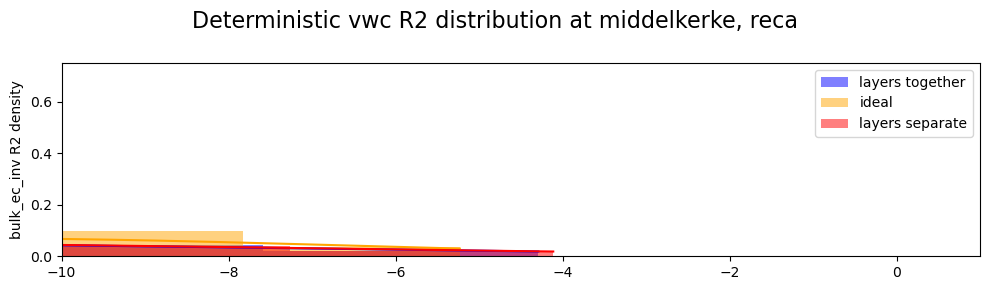

In [51]:
plot_det(Dresults, feature_set, target, profile_prefix, em_intype, cal, site, 'R2', 'blue', 'red', 'orange')

# Stochastic modelling

## Implementation

In [52]:
def stochastic(features, target, df, criteria='R2', n=4, iters=100, round_n=3):
    ### Defining lists to store results and error indicators
    SR2_train_10_, SR2_test_10_, Sypred_test_10_ = [], [], []
    SR2_train_50_, SR2_test_50_, Sypred_test_50_ = [], [], []
    SR2_train_LT_, SR2_test_LT_ = [], []
    SR2_train_LS_, SR2_test_LS_ = [], []
    y_test_ = []

    ### Extract indices for 10 cm and 50 cm layers
    idx_layer_10 = df[df['depth'] == 10].index
    idx_layer_50 = df[df['depth'] == 50].index
    ### Select data at 10 cm depth
    X_layer_10 = df.loc[idx_layer_10, features].values.reshape(-1, 1)
    Y_layer_10 = df.loc[idx_layer_10, target].values
    ### Select data at 50 cm depth
    X_layer_50 = df.loc[idx_layer_50, features].values.reshape(-1, 1)
    Y_layer_50 = df.loc[idx_layer_50, target].values

    for i in range(iters):
        ### Split data of 10cm layer and keep track of test indices
        X_train10, X_test10, y_train10, y_test10 = train_test_split(X_layer_10, Y_layer_10, test_size=0.3, random_state=i)
        SR2_train_10, SR2_test_10, Sypred_test_10 = [], [], []
        ### Split data of 50cm layer and keep track of test indices
        X_train50, X_test50, y_train50, y_test50 = train_test_split(X_layer_50, Y_layer_50, test_size=0.3, random_state=i)
        SR2_train_50, SR2_test_50, Sypred_test_50 = [], [], []
        ### Combine test indices from both layers
        y_train = np.concatenate((y_train10, y_train50))
        y_test = np.concatenate((y_test10, y_test50)).flatten()
        X_train = np.concatenate((X_train10, X_train50))
        X_test = (np.concatenate((X_test10, X_test50))/1000).flatten()
        y_test_.append(y_test)

        SR2_train_LS, SR2_test_LS = [], []
        SR2_train_LT, SR2_test_LT = [], []

        for k in range(n):

            #### Stochastic modelling for layers together
            polyLT = PolynomialFeatures(degree=k)
            polyLT.fit(X_train)
            Xt_trainLT = polyLT.transform(X_train)
            Xt_testLT = polyLT.transform(X_test.reshape(-1, 1))
            LinRegLT = LinearRegression()
            LinRegLT.fit(Xt_trainLT, y_train)
            Sypred_trainLT = LinRegLT.predict(Xt_trainLT)
            Sypred_testLT = LinRegLT.predict(Xt_testLT)
                # Save results and error indicators over polinomial degrees
            SR2_train_LT.append(round(r2_score(y_train, Sypred_trainLT), round_n))
            SR2_test_LT.append(round(r2_score(y_test, Sypred_testLT), round_n))

            #### Stochastic modelling 10 cm layer
            LinReg10 = LinearRegression()
            poly10 = PolynomialFeatures(degree=k)
            poly10.fit(X_train10)
            Xt_train10 = poly10.transform(X_train10)
            Xt_test10 = poly10.transform(X_test10)
            LinReg10.fit(Xt_train10, y_train10)
            Sypred_train10 = LinReg10.predict(Xt_train10)
            Sypred_test10 = LinReg10.predict(Xt_test10)
                # Save results and error indicators over polinomial degrees
            Sypred_test_10.append(Sypred_test10)
            SR2_train_10.append(round(r2_score(y_train10, Sypred_train10), round_n))
            SR2_test_10.append(round(r2_score(y_test10, Sypred_test10), round_n))

            #### Stochastic modelling 50 cm layer
            LinReg50 = LinearRegression()
            poly50 = PolynomialFeatures(degree=k)
            poly50.fit(X_train50)
            Xt_train50 = poly50.transform(X_train50)
            Xt_test50 = poly50.transform(X_test50)
            LinReg50.fit(Xt_train50, y_train50)
            Sypred_train50 = LinReg50.predict(Xt_train50)
            Sypred_test50 = LinReg50.predict(Xt_test50)
                # Save results and error indicators over polinomial degrees
            Sypred_test_50.append(Sypred_test50)
            SR2_train_50.append(round(r2_score(y_train50, Sypred_train50), round_n))
            SR2_test_50.append(round(r2_score(y_test50, Sypred_test50), round_n))

            ### Stochastic modelling for layers separate. 
            ### This is a combination of both layer's prediction
            Sypred_train_LS = np.concatenate((Sypred_train10, Sypred_train50))
            Sypred_test_LS = np.concatenate((Sypred_test10, Sypred_test50))

            SR2_train_LS.append(round(r2_score(y_train, Sypred_train_LS), round_n))
            SR2_test_LS.append(round(r2_score(y_test, Sypred_test_LS), round_n))

        # Save results over all splits
        SR2_train_10_.append(SR2_train_10)
        SR2_test_10_.append(SR2_test_10)
        Sypred_test_10_.append(Sypred_test_10)

        SR2_train_50_.append(SR2_train_50)
        SR2_test_50_.append(SR2_test_50)
        Sypred_test_50_.append(Sypred_test_50)

        SR2_train_LS_.append(SR2_train_LS)
        SR2_test_LS_.append(SR2_test_LS)

        SR2_train_LT_.append(SR2_train_LT)
        SR2_test_LT_.append(SR2_test_LT)

        SR2_test_LS0 = [inner_list[0] for inner_list in SR2_test_LS_]
        SR2_test_LS1 = [inner_list[1] for inner_list in SR2_test_LS_]
        SR2_test_LS2 = [inner_list[2] for inner_list in SR2_test_LS_]
        SR2_test_LS3 = [inner_list[3] for inner_list in SR2_test_LS_]

        SR2_test_LT0 = [inner_list[0] for inner_list in SR2_test_LT_]
        SR2_test_LT1 = [inner_list[1] for inner_list in SR2_test_LT_]
        SR2_test_LT2 = [inner_list[2] for inner_list in SR2_test_LT_]
        SR2_test_LT3 = [inner_list[3] for inner_list in SR2_test_LT_]
        #####

        SR2_test_10_0 = [inner_list[0] for inner_list in SR2_test_10_]
        SR2_test_10_1 = [inner_list[1] for inner_list in SR2_test_10_]
        SR2_test_10_2 = [inner_list[2] for inner_list in SR2_test_10_]
        SR2_test_10_3 = [inner_list[3] for inner_list in SR2_test_10_]

        SR2_test_50_0 = [inner_list[0] for inner_list in SR2_test_50_]
        SR2_test_50_1 = [inner_list[1] for inner_list in SR2_test_50_]
        SR2_test_50_2 = [inner_list[2] for inner_list in SR2_test_50_]
        SR2_test_50_3 = [inner_list[3] for inner_list in SR2_test_50_]

    #########################
    if criteria == 'R2':

        SR2_10 = [SR2_test_10_0, SR2_test_10_1, SR2_test_10_2, SR2_test_10_3]
        SR2_meadian_10 = [np.median(sublist) for sublist in SR2_10]
        best_n_10 = SR2_meadian_10.index(np.max(SR2_meadian_10))
        SR2_test_10b = SR2_10[best_n_10]

        SR2_50 = [SR2_test_50_0, SR2_test_50_1, SR2_test_50_2, SR2_test_50_3]
        SR2_meadian_50 = [np.median(sublist) for sublist in SR2_50]
        best_n_50 = SR2_meadian_50.index(np.max(SR2_meadian_50))
        SR2_test_50b = SR2_50[best_n_50]

        SR2_LT = [SR2_test_LT0, SR2_test_LT1, SR2_test_LT2, SR2_test_LT3]
        SR2_meadian_LT = [np.median(sublist) for sublist in SR2_LT]
        best_n_LT = SR2_meadian_LT.index(np.max(SR2_meadian_LT))
        SR2_test_LTb = SR2_LT[best_n_LT]

        SR2_LS = [SR2_test_LS0, SR2_test_LS1, SR2_test_LS2, SR2_test_LS3]
        SR2_meadian_LS = [np.median(sublist) for sublist in SR2_LS]
        best_n_LS = SR2_meadian_LS.index(np.max(SR2_meadian_LS))
        SR2_test_LSb = SR2_LS[best_n_LS]

        ### Based on the best dgrees per layer, make up the LS2 model, the one that uses models for layer which are not necesarely equal. 
        SR2_test_LS2b = []
        for j in range(iters):
            Sypred_test_10b = [inner_list[best_n_10] for inner_list in Sypred_test_10_][j]
            Sypred_test_50b = [inner_list[best_n_50] for inner_list in Sypred_test_50_][j]

            Sypred_LS2b = np.concatenate((Sypred_test_10b, Sypred_test_50b))
            SR2_test_LS2b.append(round(r2_score(y_test_[j], Sypred_LS2b), round_n))

        best_n_LS2 = [best_n_10, best_n_50]
    best_ns = [best_n_LT, best_n_LS, best_n_LS2]
    return SR2_test_LTb, SR2_test_LSb, SR2_test_LS2b, SR2_test_10b, SR2_test_50b, best_ns

ds              x            y         z         t      HCP1QP      PRP1QP  \
0  41564.53508  204206.6350  0.550000  46700.42  157.379116   76.459510   
1  41548.70351  204311.6093  0.849275  48080.26  142.726641  114.871591   
2  41589.68646  204167.8156  0.550000  46944.42  195.057966   97.199432   
3  41668.92012  204238.2888  0.450000  53527.92  186.226695   96.358249   
4  41521.64592  204334.5815  0.850000  47262.62  211.142407  167.971496   

       HCP2QP      PRP2QP      HCP4QP      PRP4QP  HCP1IP  PRP1IP  HCP2IP  \
0  236.183259  119.614470  381.794673  201.743773    2.04    0.13    7.76   
1  167.768838  114.862278  254.535261  140.259559    1.86    0.07    5.91   
2  285.734441  163.096126  420.769054  260.211860    2.16    0.10    8.15   
3  279.204712  161.183682  407.804254  259.551810    2.21    0.21    8.25   
4  263.478943  190.689823  353.187756  245.572023    1.96    0.13    6.65   

   PRP2IP  HCP4IP  PRP4IP  code     x_clhs      y_clhs  z  t  depth  humus  \
0    

c:\Users\mendo\anaconda3_2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mendo\anaconda3_2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mendo\anaconda3_2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


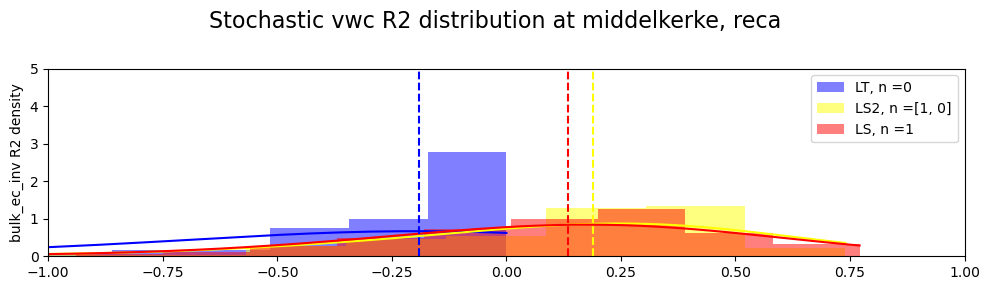

c:\Users\mendo\anaconda3_2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mendo\anaconda3_2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mendo\anaconda3_2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


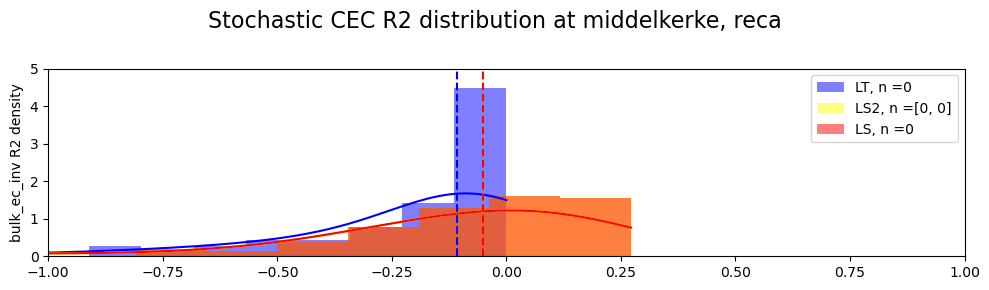

c:\Users\mendo\anaconda3_2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mendo\anaconda3_2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mendo\anaconda3_2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


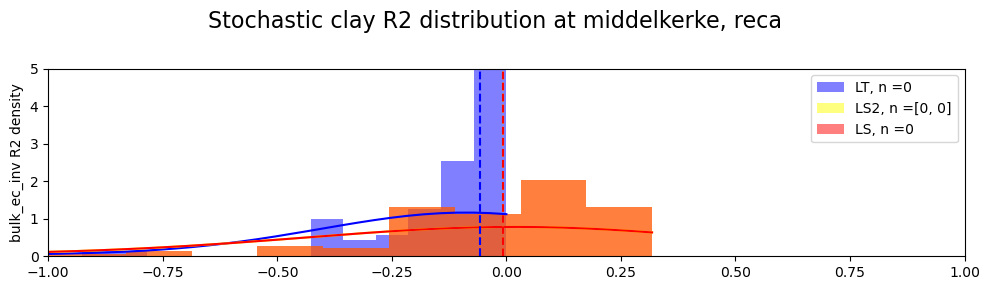

c:\Users\mendo\anaconda3_2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mendo\anaconda3_2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mendo\anaconda3_2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


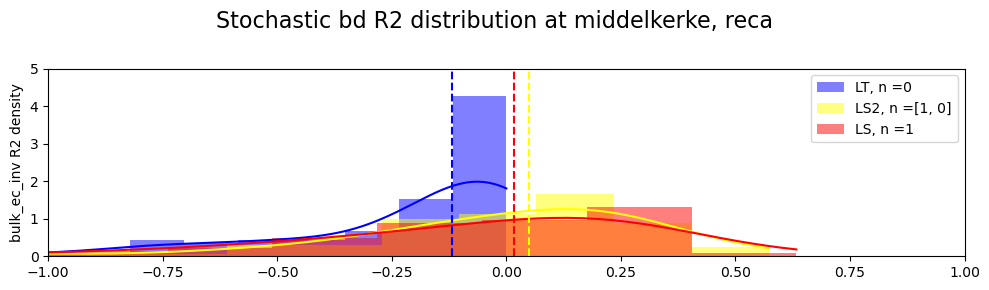

c:\Users\mendo\anaconda3_2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mendo\anaconda3_2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\mendo\anaconda3_2\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


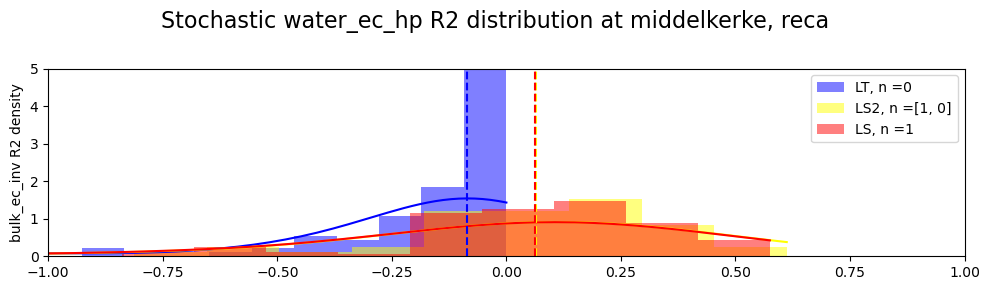

In [53]:
###########################
#### Store results ########

pdfs = []
Sresults = {}
SR2_results = pd.DataFrame(columns=['Target', 'BestFeatureLT', 'LT', 'BestFeatureLS', 'LS', 'BestFeatureLS2', 'LS2'
                               , 'BestFeature10', 'Top_layer', 'BestFeature50', 'Bottom_layer'])

print('ds', ds.head())
print('feature_set', feature_set)
for i, target in enumerate(target_set):
    max_r2_lt = -float('inf')
    max_r2_ls = -float('inf')
    max_r2_ls2 = -float('inf')
    max_r2_10 = -float('inf')
    max_r2_50 = -float('inf')
    best_feature_lt = None
    best_feature_ls = None
    best_feature_ls2 = None

    for feature in feature_set:
        SR2_test_LT, SR2_test_LS, SR2_test_LS2, SR2_test_10, SR2_test_50, best_ns = stochastic(feature, target, ds)

        Sresults[feature] = {
            'LT': {'R2': SR2_test_LT, 'n': best_ns[0]},
            'LS': {'R2': SR2_test_LS, 'n': best_ns[1]},
            'LS2': {'R2': SR2_test_LS2, 'n': best_ns[2]},
            '10': {'R2': SR2_test_10, 'n': best_ns[2]},
            '50': {'R2': SR2_test_50, 'n': best_ns[2]}
        }

    for feature, result in Sresults.items():
        if np.median(result['LT']['R2']) > max_r2_lt:
            max_r2_lt = np.median(result['LT']['R2'])
            best_feature_lt = feature

        if np.median(result['LS']['R2']) > max_r2_ls:
            max_r2_ls = np.median(result['LS']['R2'])
            best_feature_ls = feature

        if np.median(result['LS2']['R2']) > max_r2_ls2:
            max_r2_ls2 = np.median(result['LS2']['R2'])
            best_feature_ls2 = feature

        if np.median(result['10']['R2']) > max_r2_10:
            max_r2_10 = np.median(result['10']['R2'])
            best_feature_10 = feature

        if np.median(result['50']['R2']) > max_r2_50:
            max_r2_50 = np.median(result['50']['R2'])
            best_feature_50 = feature

    SR2_results.loc[i, 'Target'] = target
    SR2_results.loc[i, 'BestFeatureLT'] = best_feature_lt
    SR2_results.loc[i, 'LT'] = max_r2_lt
    SR2_results.loc[i, 'BestFeatureLS'] = best_feature_ls
    SR2_results.loc[i, 'LS'] = max_r2_ls
    SR2_results.loc[i, 'BestFeatureLS2'] = best_feature_ls2
    SR2_results.loc[i, 'LS2'] = max_r2_ls2
    SR2_results.loc[i, 'BestFeature10'] = best_feature_10
    SR2_results.loc[i, 'Top_layer'] = max_r2_10
    SR2_results.loc[i, 'BestFeature50'] = best_feature_50
    SR2_results.loc[i, 'Bottom_layer'] = max_r2_50

    file_name = plot_stoch(Sresults, feature_set, target, profile_prefix, em_intype, cal, site, 'R2', 'blue', 'red', 'yellow')
    pdfs.append(file_name)

In [54]:
folder_path = 'output_images/'

# Merge and save PDFs
merger = PdfMerger()
for pdf in pdfs:
    merger.append(folder_path + pdf)
merged_pdf_filename = f"R2_stoch_{site}_{cal}_{em_intype}.pdf"
outfile_transect_pdf = os.path.join(folder_path, merged_pdf_filename)
merger.write(outfile_transect_pdf)
merger.close()
for pdf in pdfs:
    os.remove(folder_path + pdf)
clear_output(wait=False)

In [55]:
folder_path = 'output_tables/'

if inv == False:
    if cal == 'calibrated':
        file_name = f'output_tables/{site}_SR2_results_{extract}_{cal}_{em_intype}.csv'

    elif cal == 'non_calibrated':
        file_name = f'output_tables/{site}_SR2_results_{cal}_LIN.csv'
else:
    file_name = f'output_tables/{site}_SR2_results_{extract}_{sample_loc}_{interface}_{FM}_{MinM}_{alpha}_{remove_coil}_{start_avg}_{constrain}_inv.csv'

SR2_results.to_csv(file_name, index=False)

SR2_results

,Target,BestFeatureLT,LT,BestFeatureLS,LS,BestFeatureLS2,LS2,BestFeature10,Top_layer,BestFeature50,Bottom_layer
0,vwc,bulk_ec_inv,-0.1905,bulk_ec_inv,0.1345,bulk_ec_inv,0.189,bulk_ec_inv,0.3015,bulk_ec_inv,-0.1955
1,CEC,bulk_ec_inv,-0.1085,bulk_ec_inv,-0.0515,bulk_ec_inv,-0.0515,bulk_ec_inv,-0.2035,bulk_ec_inv,-0.2135
2,clay,bulk_ec_inv,-0.058,bulk_ec_inv,-0.0065,bulk_ec_inv,-0.0065,bulk_ec_inv,-0.315,bulk_ec_inv,-0.1785
3,bd,bulk_ec_inv,-0.119,bulk_ec_inv,0.0175,bulk_ec_inv,0.049,bulk_ec_inv,0.409,bulk_ec_inv,-0.198
4,water_ec_hp,bulk_ec_inv,-0.087,bulk_ec_inv,0.0625,bulk_ec_inv,0.064,bulk_ec_inv,-0.146,bulk_ec_inv,-0.175


feature_10 bulk_ec_inv
feature_50 bulk_ec_inv


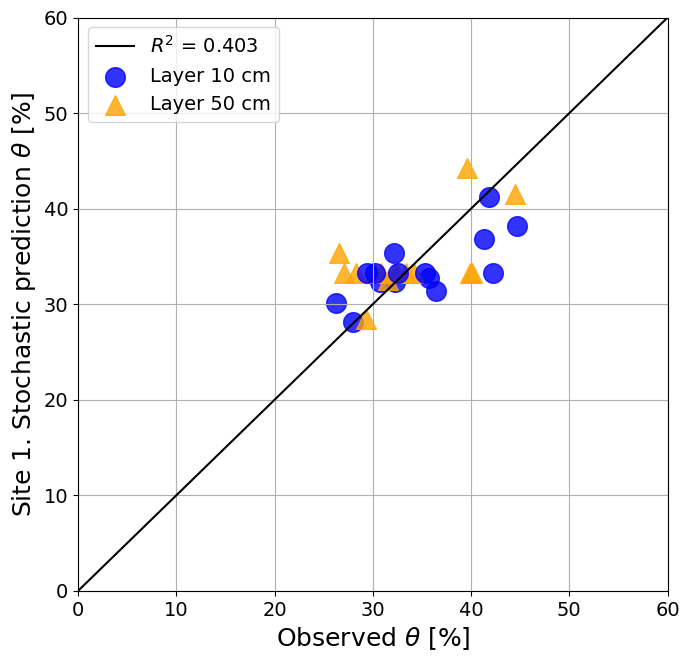

In [56]:
if site == 'P':

    round_n = 3
    target = 'vwc'

    feature_10 = SR2_results[SR2_results['Target'] == 'vwc']['BestFeature10'].iloc[0]
    feature_50 = SR2_results[SR2_results['Target'] == 'vwc']['BestFeature50'].iloc[0]
    print('feature_10', feature_10)
    print('feature_50', feature_50)

    n_10 = Sresults[feature_10]['LS2']['n'][0]
    n_50 = Sresults[feature_50]['LS2']['n'][1]

    ### Extract indices for 10 cm and 50 cm layers
    idx_10 = ds[ds['depth'] == 10].index
    idx_50 = ds[ds['depth'] == 50].index

    ### Select data at 10 cm depth
    X_10 = ds.loc[idx_10, feature_10].values.reshape(-1, 1)
    Y_10 = ds.loc[idx_10, target].values
    ### Select data at 50 cm depth
    X_50 = ds.loc[idx_50, feature_50].values.reshape(-1, 1)
    Y_50 = ds.loc[idx_50, target].values

    #### Stochastic modelling for layers together
    polySP_10 = PolynomialFeatures(degree=n_10)
    polySP_10.fit(X_10)

    Xt_10 = polySP_10.transform(X_10)
    #Yt_10 = polySP_10.transform(Y_10)

    LinRegSP = LinearRegression()
    LinRegSP.fit(Xt_10, Y_10)
    Ypred_10 = LinRegSP.predict(Xt_10)

    #### Stochastic modelling for layers together
    polySP_50 = PolynomialFeatures(degree=n_50)
    polySP_50.fit(X_50)

    Xt_50 = polySP_50.transform(X_50)

    LinRegSP = LinearRegression()
    LinRegSP.fit(Xt_50, Y_50)
    Ypred_50 = LinRegSP.predict(Xt_50)

    Y = np.concatenate((Y_10, Y_50))
    Y_pred = np.concatenate((Ypred_10, Ypred_50))

    r2 = round(r2_score(Y, Y_pred), round_n)

    f8(ds, Y, Y_pred, r2, profile_prefix)


if site == 'M':

    round_n = 3
    target = 'vwc'

    feature_10 = SR2_results[SR2_results['Target'] == 'vwc']['BestFeature10'].iloc[0]
    feature_50 = SR2_results[SR2_results['Target'] == 'vwc']['BestFeature50'].iloc[0]
    print('feature_10', feature_10)
    print('feature_50', feature_50)

    n_10 = Sresults[feature_10]['LS2']['n'][0]
    n_50 = Sresults[feature_50]['LS2']['n'][1]

    ### Extract indices for 10 cm and 50 cm layers
    idx_10 = ds[ds['depth'] == 10].index
    idx_50 = ds[ds['depth'] == 50].index

    ### Select data at 10 cm depth
    X_10 = ds.loc[idx_10, feature_10].values.reshape(-1, 1)
    Y_10 = ds.loc[idx_10, target].values
    ### Select data at 50 cm depth
    X_50 = ds.loc[idx_50, feature_50].values.reshape(-1, 1)
    Y_50 = ds.loc[idx_50, target].values

    #### Stochastic modelling for layers together
    polySP_10 = PolynomialFeatures(degree=n_10)
    polySP_10.fit(X_10)

    Xt_10 = polySP_10.transform(X_10)
    #Yt_10 = polySP_10.transform(Y_10)

    LinRegSP = LinearRegression()
    LinRegSP.fit(Xt_10, Y_10)
    Ypred_10 = LinRegSP.predict(Xt_10)

    #### Stochastic modelling for layers together
    polySP_50 = PolynomialFeatures(degree=n_50)
    polySP_50.fit(X_50)

    Xt_50 = polySP_50.transform(X_50)

    LinRegSP = LinearRegression()
    LinRegSP.fit(Xt_50, Y_50)
    Ypred_50 = LinRegSP.predict(Xt_50)

    Y = np.concatenate((Y_10, Y_50))
    Y_pred = np.concatenate((Ypred_10, Ypred_50))

    r2 = round(r2_score(Y, Y_pred), round_n)

    f8(ds, Y, Y_pred, r2, profile_prefix)

inv_columns Index(['EC_0.30', 'EC_0.60', 'EC_1.00', 'EC_2.00', 'EC_end'], dtype='object')
inv_columns Index(['EC_0.30', 'EC_0.60', 'EC_1.00', 'EC_2.00', 'EC_end'], dtype='object')


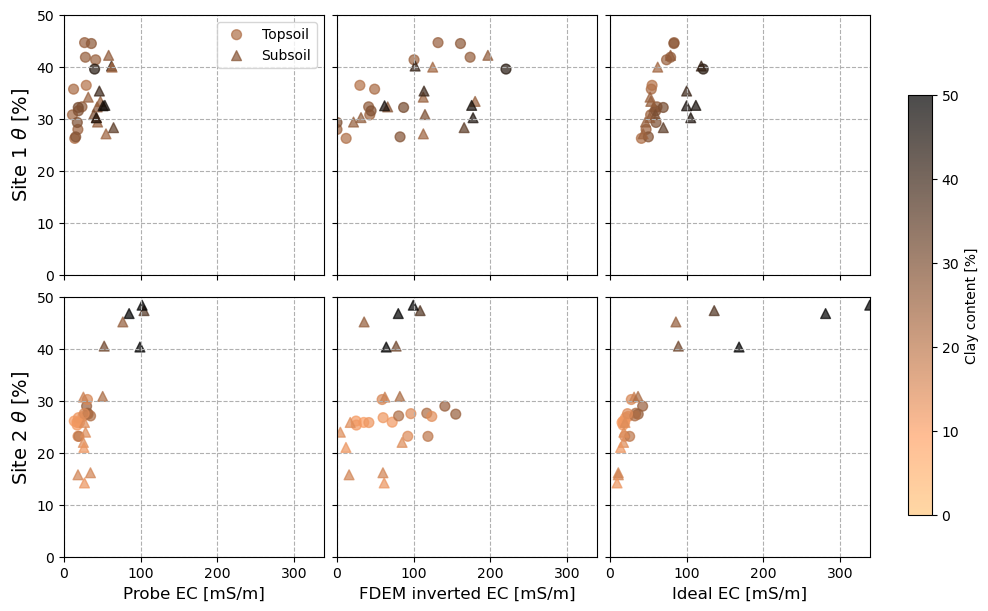

In [57]:
# Parameters
extract = 0.5 # 2.5 
# Inversion parameters
sample_loc = 'closest' # 'mean' or 'closest'
interface = 'observed' # log-defined or observed
FM = 'FSeq' #'CS', 'FSlin' or 'FSeq'
MinM = 'Gauss-Newton'  
alpha = 0.07
remove_coil = False
start_avg = True
constrain = False
################################################
# Define input datatype and source folder
inv = True

em_intype = 'reca'   # 'reca', 'LIN' 
cal = 'calibrated' # 'calibrated', 'non_calibrated', 'drift_calibrated'

for emfile_prefix in ['middelkerke_421S', 'proefhoeve_21HS']:
    if emfile_prefix == 'middelkerke_421S':
        profile_prefix = 'middelkerke'
        
    elif emfile_prefix == 'proefhoeve_21HS':
        profile_prefix = 'proefhoeve'

    inv_s = os.path.join(data_inv_folder, f'{emfile_prefix}_inverted_samples_{extract}_{sample_loc}_{interface}_{FM}_{MinM}_{alpha}_{remove_coil}_{start_avg}_{constrain}.csv')

    cal_folder = os.path.join(datafolder, cal)

    em_survey = os.path.join(cal_folder, f'{emfile_prefix}_raw_{cal}_{em_intype}_{extract}.csv')

    sampleprop = os.path.join(data_sanalysis_folder, f'{profile_prefix}_soil_analysis.csv')
    # Profile smoothing parameters 
    window_size = 1 # Define your window size for simple moving average filter (1 = no filtering)

    # 1.0 Data import and structuring into dataframe
    em_survey = pd.read_csv(em_survey, sep=',', header=0)

    inverted = pd.read_csv(inv_s, sep=',', header=0)
    samples_analysis = pd.read_csv(sampleprop, sep=',', header=0)

    em_sample_prop = get_coincident(em_survey, samples_analysis)

    ds = em_sample_prop.copy()

    # Caclculate Bulk EC from HydraProbe data at 50Mhz
    offset = 4
    water_perm = 80
    ds['bulk_ec_dc_hp'] = logsdon(50e6, ds.rperm, ds.iperm)

    ds['bulk_ec_dcdc_hp'] = predict.BulkECDC(Soil(frequency_ec = 50e6,
                                                bulk_ec = ds.bulk_ec_dc_hp.values))

    ds['bulk_ec_dc_tc_hp'] = predict.BulkECDCTC(Soil(temperature = ds.temp.values+273.15,
                                                        bulk_ec_dc = ds.bulk_ec_dc_hp.values))

    # Caclculate Water EC from HydraProbe data at 50Mhz
    ds['water_ec_hp'] = Hilhorst(ds.bulk_ec_dc_hp, ds.rperm, water_perm, offset)
    ds['water_ec_hp_t'] = WraithOr(ds.water_ec_hp, ds.temp)
    ds['iperm_water_t'] = ds.water_ec_hp_t/(50e6*2*pi*epsilon_0)

    inv_columns = inverted.columns[3:-2]
    print('inv_columns', inv_columns)
    ds[inv_columns] = np.nan

    for idc, c in enumerate(inv_columns):

        for i in range(len(inverted.x)):
            ds.loc[ds.code == i+1, c] = inverted.loc[i, c]

    # Apply the function to each row
    ds['bulk_ec_inv'] = ds.apply(closest_ec, axis=1)
    ds['bulk_ec_inv_mS'] = ds.bulk_ec_inv/1000

    ds['bulk_ec_dc_tc_inv'] = predict.BulkECDCTC(Soil(temperature = ds.temp.values+273.15,
                                                        frequency_ec = 9e3,
                                                        bulk_ec = ds.bulk_ec_inv.values/1000))

    ds['ideal_bulk_ec_dc'] = predict.BulkECDC(
                                            Soil(temperature = ds.temp.values+273.15,
                                                water = ds.vwc.values,
                                                clay = ds.clay.values,
                                                bulk_density = ds.bd.values,
                                                water_ec = ds.water_ec_hp.values,
                                                frequency_ec = 9e3
                                                ))
    
    ds['ideal_bulk_ec_dc_tc'] = predict.BulkECDCTC(
                                        Soil(temperature = ds.temp.values+273.15,
                                            water = ds.vwc.values,
                                            clay = ds.clay.values,
                                            bulk_density = ds.bd.values,
                                            water_ec = ds.water_ec_hp.values,
                                            frequency_ec = 9e3
                                            ))
    
    ds['res_ideal_hp'] = ds.ideal_bulk_ec_dc_tc - ds.bulk_ec_dc_tc_hp

    if emfile_prefix == 'middelkerke_421S':
        d1 = ds

    elif emfile_prefix == 'proefhoeve_21HS':
        d2 = ds

preds = ['bulk_ec_dc_tc_hp', 'bulk_ec_dc_tc_inv', 'ideal_bulk_ec_dc_tc']
f6(d1, d2, ['vwc'], preds)

In [58]:
Dresults = {}
DR2_LT, DRMSE_LT, DR2_ID, DRMSE_ID, DR2_LS, DRMSE_LS, DR2_10, DRMSE_10, DR2_50, DRMSE_50 = deterministic('bulk_ec_dc_tc_hp', 'vwc', ds)
print(DR2_LT, DRMSE_LT, DR2_ID, DRMSE_ID, DR2_LS, DRMSE_LS, DR2_10, DRMSE_10, DR2_50, DRMSE_50)
Dresults['bulk_ec_inv'] = {
      'LT': {'R2': DR2_LT, 'RMSE': DRMSE_LT},
      'LS': {'R2': DR2_LS, 'RMSE': DRMSE_LS},
      'ID': {'R2': DR2_ID, 'RMSE': DRMSE_ID},
'layer 10': {'R2': DR2_10, 'RMSE': DRMSE_10},
'layer 50': {'R2': DR2_50, 'RMSE': DRMSE_50}
}

# Convert results to DataFrame for easier processing
Dresults_df = pd.DataFrame(Dresults).T.stack().reset_index()
Dresults_df.columns = ['Feature', 'Model', 'Scores']
Dresults_df = Dresults_df.join(pd.DataFrame(Dresults_df.pop('Scores').values.tolist()))

# Calculate median of each list in RMSE and R2 columns
Dresults_df['Median RMSE'] = Dresults_df['RMSE'].apply(lambda x: np.median(x))
Dresults_df['Median R2'] = Dresults_df['R2'].apply(lambda x: np.median(x))

# Create a DataFrame for median scores
median_scores = Dresults_df[['Feature', 'Model', 'Median RMSE', 'Median R2']]
print('median_scores', median_scores)

# Find best features based on criteria
error_criteria = 'R2'  # Change to 'R2' to select based on R2
if error_criteria == 'RMSE':
    best_features = median_scores.loc[median_scores.groupby('Model')['Median RMSE'].idxmin()]
else:
    best_features = median_scores.loc[median_scores.groupby('Model')['Median R2'].idxmax()]

# Prepare final DataFrame
DR2_results = pd.DataFrame({
    'Target': target,
    'Best Feature LT': best_features.loc[best_features['Model'] == 'LT', 'Feature'].values[0],
    'R2 LT':           best_features.loc[best_features['Model'] == 'LT', 'Median R2'].values[0],
    'Best Feature ID': best_features.loc[best_features['Model'] == 'ID', 'Feature'].values[0],
    'R2 ID':           best_features.loc[best_features['Model'] == 'ID', 'Median R2'].values[0],
    'Best Feature LS': best_features.loc[best_features['Model'] == 'LS', 'Feature'].values[0],
    'R2 LS':           best_features.loc[best_features['Model'] == 'LS', 'Median R2'].values[0],
    'Best Feature 10': best_features.loc[best_features['Model'] == 'layer 10', 'Feature'].values[0],
    'R2 10':           best_features.loc[best_features['Model'] == 'layer 10', 'Median R2'].values[0],
    'Best Feature 50': best_features.loc[best_features['Model'] == 'layer 50', 'Feature'].values[0],
    'R2 50':           best_features.loc[best_features['Model'] == 'layer 50', 'Median R2'].values[0]
}, index=[0])

#folder_path = 'output_tables/'
#file_name = 'DR2_results' + '_' + site + '_' + em_intype + '_' + cal + '_' + instrument_code + '.csv'
#DR2_results.to_csv(folder_path + file_name, index=False)
#DR2_results

bulk_ec_inv_data = median_scores[median_scores['Feature'] == 'bulk_ec_inv']

DR2_results_inv = pd.DataFrame({
    'Target': target,
    'Inverted EC LT R2': bulk_ec_inv_data.loc[bulk_ec_inv_data['Model'] == 'LT', 'Median R2'].values[0],
    'Inverted EC ID R2': bulk_ec_inv_data.loc[bulk_ec_inv_data['Model'] == 'ID', 'Median R2'].values[0],
    'Inverted EC LS R2': bulk_ec_inv_data.loc[bulk_ec_inv_data['Model'] == 'LS', 'Median R2'].values[0],
    'Inverted EC 10 R2': bulk_ec_inv_data.loc[bulk_ec_inv_data['Model'] == 'layer 10', 'Median R2'].values[0],
    'Inverted EC 50 R2': bulk_ec_inv_data.loc[bulk_ec_inv_data['Model'] == 'layer 50', 'Median R2'].values[0],
    }, index=[0])

#folder_path = 'output_tables/'
#file_name = 'DR2_results_inv_' + '_' + site + '_' + em_intype + '_' + cal + '_' + instrument_code + '.csv'
#DR2_results_inv.to_csv(folder_path + file_name, index=False)
DR2_results_inv

[-16.577, -10.794, -11.087, -10.909, -12.816, -9.446, -7.504, -12.654, -7.671, -7.993, -17.713, -18.189, -11.475, -9.45, -12.258, -13.277, -8.213, -13.261, -9.548, -11.708, -17.318, -12.703, -14.288, -10.299, -17.132, -10.618, -9.217, -11.073, -12.645, -9.248, -9.584, -14.904, -12.137, -17.788, -18.365, -8.8, -10.618, -12.778, -8.815, -9.917, -14.338, -11.477, -8.025, -7.956, -11.313, -10.053, -13.359, -9.374, -7.326, -14.709, -9.261, -13.247, -12.045, -34.581, -11.871, -8.01, -20.781, -13.078, -23.2, -11.073, -11.538, -10.796, -12.994, -13.635, -11.099, -8.93, -30.848, -15.598, -16.176, -15.87, -12.239, -10.695, -7.956, -7.657, -13.095, -9.237, -12.583, -11.217, -14.327, -10.921, -12.522, -9.889, -10.994, -9.259, -18.285, -11.205, -25.968, -9.829, -11.978, -14.022, -16.577, -19.34, -7.5, -10.181, -9.076, -14.219, -9.281, -13.635, -15.87, -15.85] [0.296, 0.269, 0.353, 0.325, 0.314, 0.304, 0.261, 0.329, 0.284, 0.288, 0.264, 0.294, 0.296, 0.288, 0.298, 0.349, 0.288, 0.316, 0.277, 0.285, 

,Target,Inverted EC LT R2,Inverted EC ID R2,Inverted EC LS R2,Inverted EC 10 R2,Inverted EC 50 R2
0,vwc,-11.623,-11.5425,-11.623,-274.586,-8.468


c:\Users\mendo\anaconda3_2\Lib\site-packages\seaborn\matrix.py:260: FutureWarning: Format strings passed to MaskedConstant are ignored, but in future may error or produce different behavior
  annotation = ("{:" + self.fmt + "}").format(val)


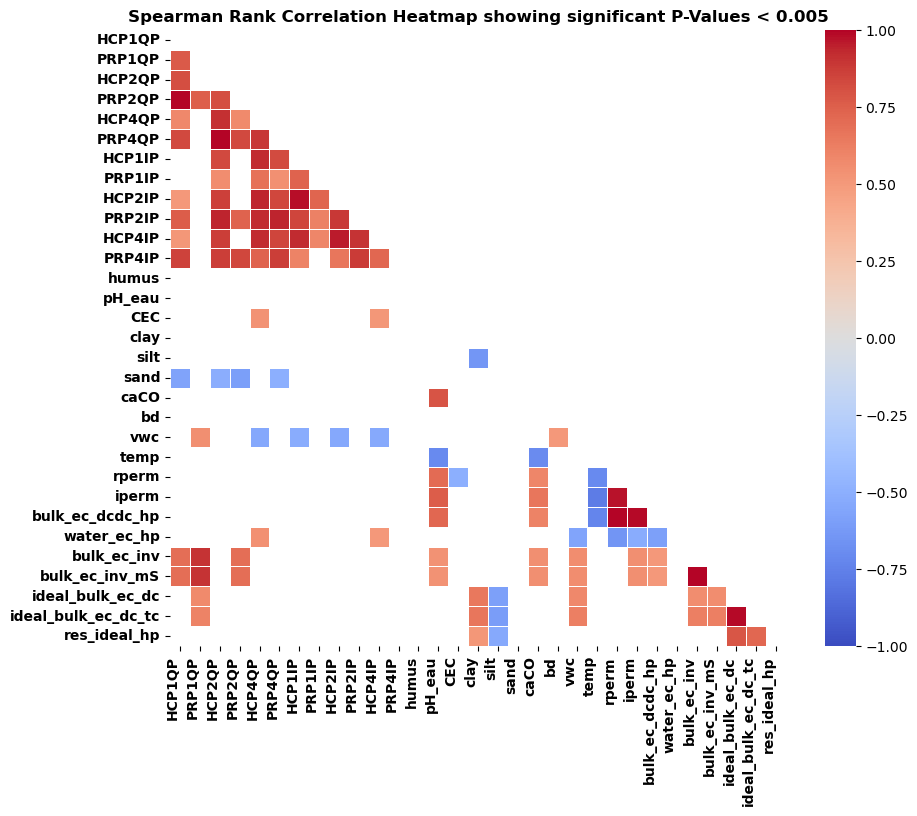

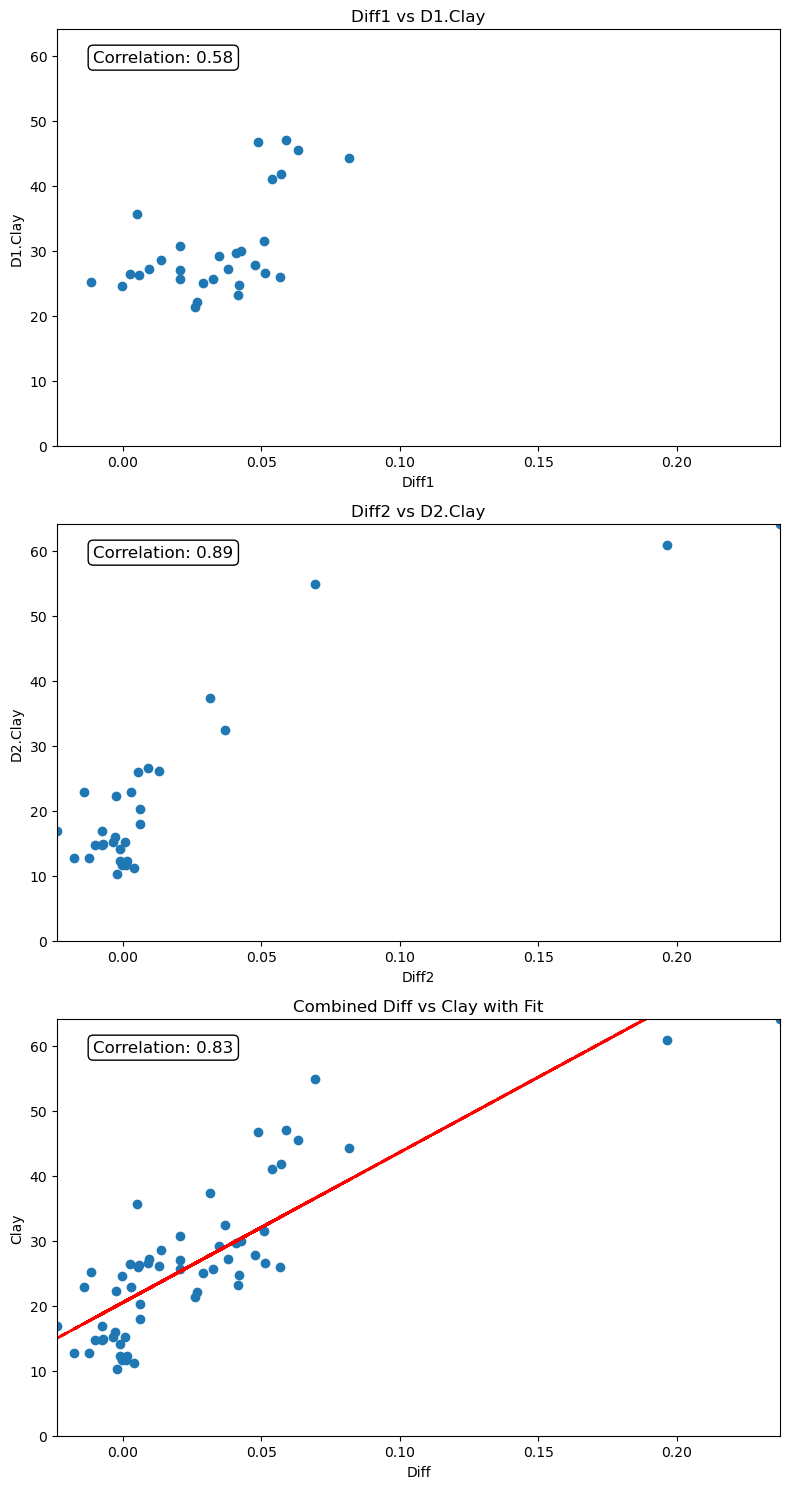

In [59]:
filtered_features = ['x', 'y', 'z', 't', 'geometry', 'code', 'TOC', 'x_clhs', 'y_clhs', 'depth', 'copeky', 'bulk_ec_dc_hp', 'bulk_ec_tc_hp', 'bulk_ec_dc_tc_hp', 'water_ec_hp_t', 'iperm_water_t', 'bulk_ec_dc_tc_inv']

# Filter out columns that start with 'EC_' and are not constant
non_ec_columns = [col for col in d1.columns if col not in filtered_features and not col.startswith('EC_') and not col.endswith('_inph')]

# Calculate the Spearman rank correlation coefficients and p-values
corr, p_value = spearmanr(d1[non_ec_columns], nan_policy='omit')

# Convert to DataFrame for easier plotting
corr_df = pd.DataFrame(corr, index=non_ec_columns, columns=non_ec_columns)
p_value_df = pd.DataFrame(p_value, index=non_ec_columns, columns=non_ec_columns)

# Create a mask for significant p-values (e.g., p < 0.01)
p_value_mask = 0.005
significant_mask = p_value_df < p_value_mask

# Mask for the upper triangle
mask = np.triu(np.ones_like(corr_df, dtype=bool))

# Combine the masks
final_mask = mask | ~significant_mask

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_df, mask=final_mask, annot=True, fmt=".2f", cmap='coolwarm', square=True, linewidths=.5, vmin=-1, vmax=1, annot_kws={"size": 8})

# Adjust layout for better readability
plt.xticks(rotation=90, ha='right', fontsize=10, fontweight='bold')
plt.yticks(rotation=0, fontsize=10, fontweight='bold')
plt.title('Spearman Rank Correlation Heatmap showing significant P-Values < '+str(p_value_mask), fontsize=12, fontweight='bold')

# Show the plot

#folder_path = 'output_images/'
#filename = f"Corr_{site}_{cal}_{em_intype}.pdf"
#plt.savefig(folder_path + filename)
#plt.show()



def f10(feat):
    # Create a figure and axes
    fig, axs = plt.subplots(3, 1, figsize=(8, 15))
    corr1 = np.corrcoef(d1.res_ideal_hp, d1[feat])[0, 1]
    corr2 = np.corrcoef(d2.res_ideal_hp, d2[feat])[0, 1]

    # Define global x and y limits
    x_min = min(d1.res_ideal_hp.min(), d2.res_ideal_hp.min())
    x_max = max(d1.res_ideal_hp.max(), d2.res_ideal_hp.max())
    y_max = max(d1[feat].max(), d2[feat].max())

    # Top row plot: diff1 vs d1.clay
    axs[0].scatter(d1.res_ideal_hp, d1[feat], marker='o')
    axs[0].set_title('Diff1 vs D1.Clay')
    axs[0].set_xlabel('Diff1')
    axs[0].set_ylabel('D1.Clay')
    axs[0].set_xlim(x_min, x_max)
    axs[0].set_ylim(0, y_max)
    # Annotate with correlation
    axs[0].annotate(f'Correlation: {corr1:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', 
                    fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

    # Middle row plot: diff2 vs d2.clay
    axs[1].scatter(d2.res_ideal_hp, d2[feat], marker='o')
    axs[1].set_title('Diff2 vs D2.Clay')
    axs[1].set_xlabel('Diff2')
    axs[1].set_ylabel('D2.Clay')
    axs[1].set_xlim(x_min, x_max)
    axs[1].set_ylim(0, y_max)
    axs[1].annotate(f'Correlation: {corr2:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', 
                    fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

    # Combine data
    combined_x = np.concatenate((d1.res_ideal_hp, d2.res_ideal_hp))
    combined_y = np.concatenate((d1[feat], d2[feat]))
    corr_combined = np.corrcoef(combined_x, combined_y)[0, 1]

    # Fit a linear function to the combined data
    slope, intercept, r_value, p_value, std_err = stats.linregress(combined_x, combined_y)
    fit_line = slope * combined_x + intercept

    # Bottom row plot: combined data
    axs[2].scatter(combined_x, combined_y, marker='o')
    axs[2].plot(combined_x, fit_line, color='red', linestyle='--', linewidth=2)
    axs[2].set_title('Combined Diff vs Clay with Fit')
    axs[2].set_xlabel('Diff')
    axs[2].set_ylabel('Clay')
    axs[2].set_xlim(x_min, x_max)
    axs[2].set_ylim(0, y_max)
    axs[2].annotate(f'Correlation: {corr_combined:.2f}', xy=(0.05, 0.95), xycoords='axes fraction', 
                    fontsize=12, verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

    # Adjust layout
    plt.tight_layout()
    # Show plot
    plt.show()

f10('clay')

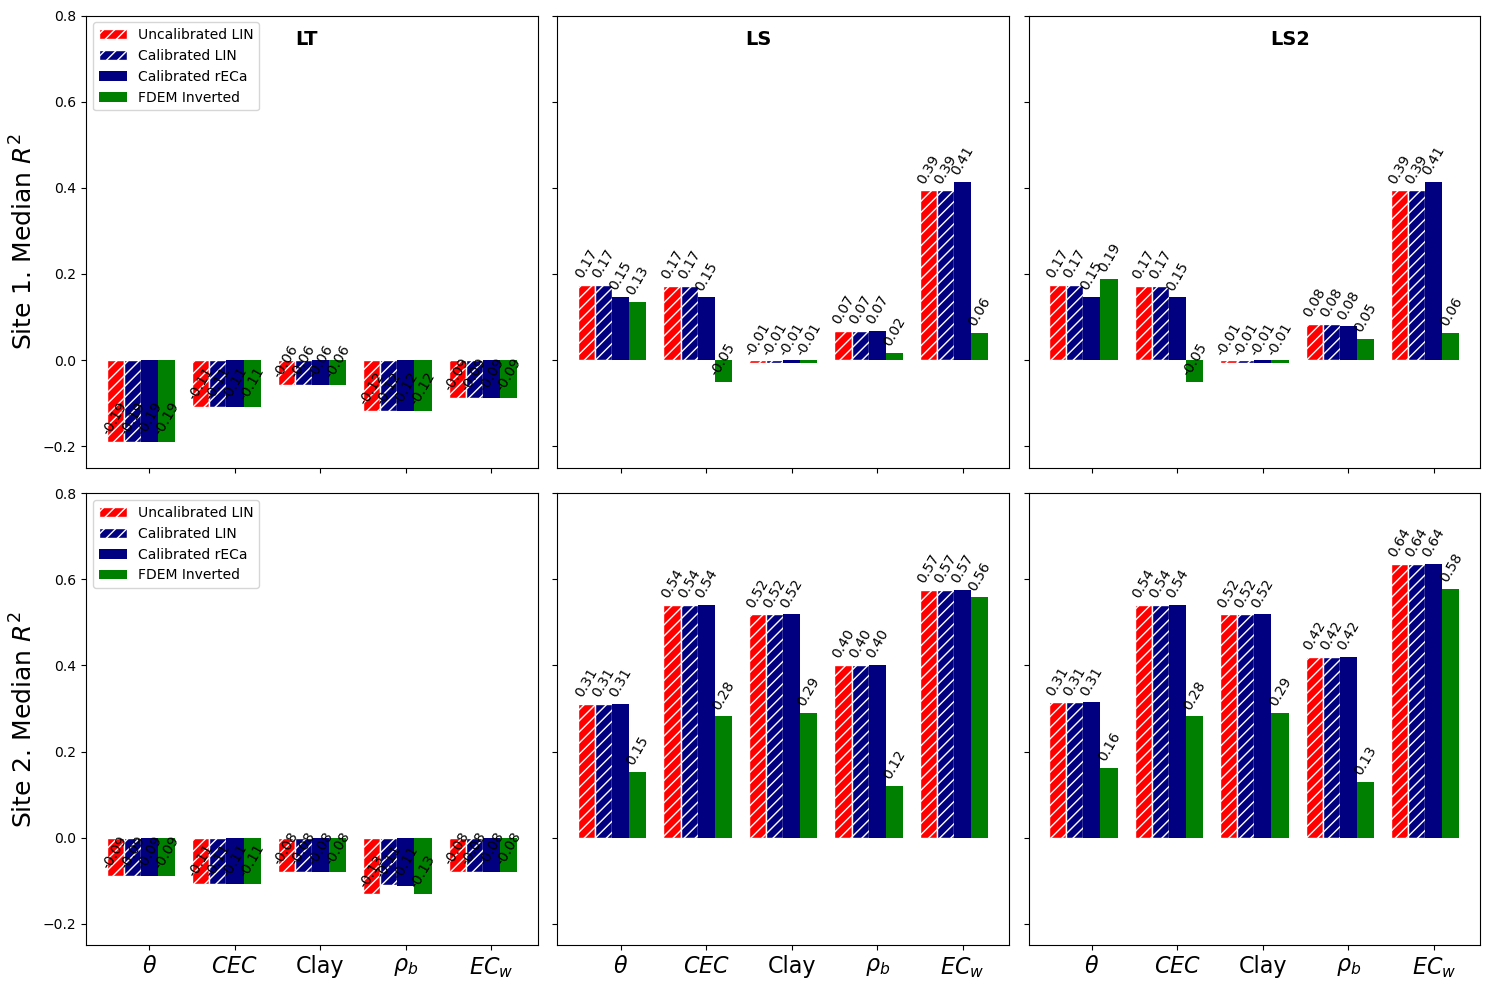

In [60]:
uncal_LIN_P_res = pd.read_csv(f'output_tables/P_SR2_results_non_calibrated_LIN.csv')
cal_LIN_P_res = pd.read_csv(f'output_tables/P_SR2_results_{extract}_calibrated_LIN.csv')
cal_rECa_P_res = pd.read_csv(f'output_tables/P_SR2_results_{extract}_calibrated_reca.csv')
inv_P_res = pd.read_csv(f'output_tables/P_SR2_results_{extract}_{sample_loc}_{interface}_{FM}_{MinM}_{alpha}_{remove_coil}_{start_avg}_{constrain}_inv.csv')

uncal_LIN_M_res = pd.read_csv(f'output_tables/M_SR2_results_non_calibrated_LIN.csv')
cal_LIN_M_res = pd.read_csv(f'output_tables/M_SR2_results_{extract}_calibrated_LIN.csv')
cal_rECa_M_res = pd.read_csv(f'output_tables/M_SR2_results_{extract}_calibrated_reca.csv')
inv_M_res = pd.read_csv(f'output_tables/M_SR2_results_{extract}_{sample_loc}_{interface}_{FM}_{MinM}_{alpha}_{remove_coil}_{start_avg}_{constrain}_inv.csv')

target_set = [
    '${θ}$',
    '${CEC}$',
    'Clay',
    '${ρ_b}$',
    '${EC_w}$']

approaches = ['LT', 'LS', 'LS2']

f7(uncal_LIN_M_res, cal_LIN_M_res, cal_rECa_M_res, inv_M_res, uncal_LIN_P_res, cal_LIN_P_res, cal_rECa_P_res, inv_P_res, target_set, approaches)